# Simple example of stationary noise and weak signals

In [7]:
# Frank Ohme
# for the PHAROS PhD School, March 2019 Jena, Germany

In [8]:
%matplotlib notebook
import numpy as np
import sys
import matplotlib
from matplotlib import pyplot as plt

In [9]:
print('Python version ' + sys.version)
print('numpy version ' + np.__version__)
print('matplotlib version ' + matplotlib.__version__)

Python version 3.7.6 (default, Jan  8 2020, 13:42:34) 
[Clang 4.0.1 (tags/RELEASE_401/final)]
numpy version 1.18.1
matplotlib version 3.1.3


## Generate noisy data and signal

In [10]:
# Here, we simulate a data set covering 1 second of noisy data, sampled at 10kHz 
# (i.e., 10 samples per millisecond).
# We generate white Gaussian noise.

dt = 1./10000.;
data_size = 20000;
data_times = np.arange(data_size) * dt

noisy_data = np.random.normal(scale = 1.0, size = data_size)

In [11]:
# As signal, we assume a sinusoidal oscillation with finite length.

signal_frequency = 100.
signal_size = 200
signal_times = np.arange(signal_size) * dt

signal = 1.0 * np.sin(2*np.pi * signal_frequency * signal_times)

<IPython.core.display.Javascript object>


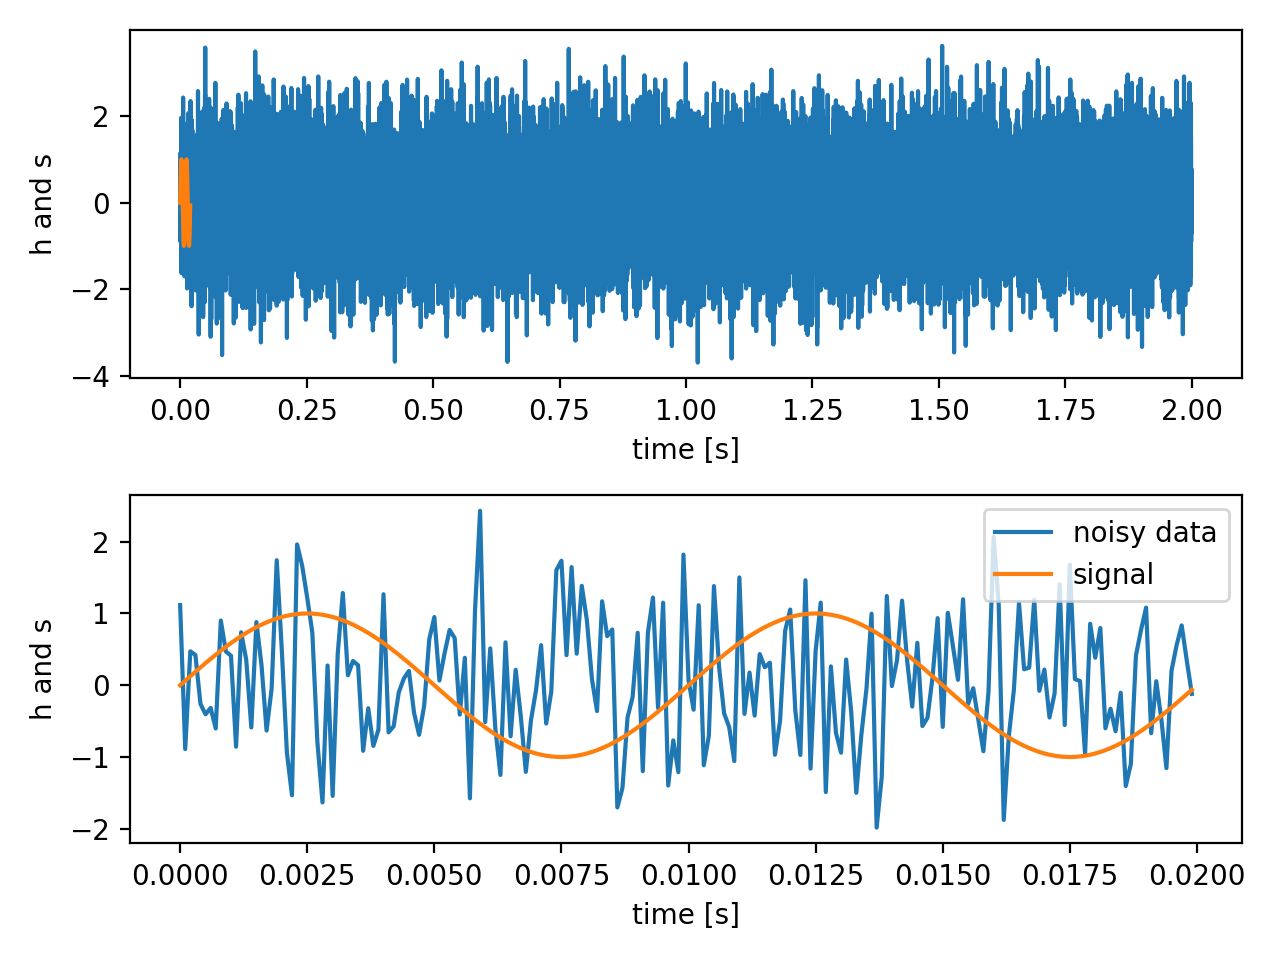

In [12]:
fig, axs = plt.subplots(2, 1)
axs[1].plot(signal_times, noisy_data[:signal_size], label='noisy data')
axs[1].plot(signal_times, signal, label='signal')
axs[1].set_xlabel('time [s]')
axs[1].set_ylabel('h and s')
axs[1].legend()
axs[0].plot(data_times, noisy_data, label='noisy data')
axs[0].plot(signal_times, signal, label='signal')
axs[0].set_xlabel('time [s]')
axs[0].set_ylabel('h and s')
plt.tight_layout()

## Fourier transforms

In [13]:
# Let's calculate the Fourier transforms of noise and signal

frequencies = np.fft.rfftfreq(data_size, dt)
df = frequencies[1]  # spacing in frequency space

In [14]:
noise_fourier = np.fft.rfft(noisy_data, norm='ortho') * np.sqrt(dt) 
signal_fourier = np.fft.rfft(signal, norm=None, n = data_size) * dt

<IPython.core.display.Javascript object>


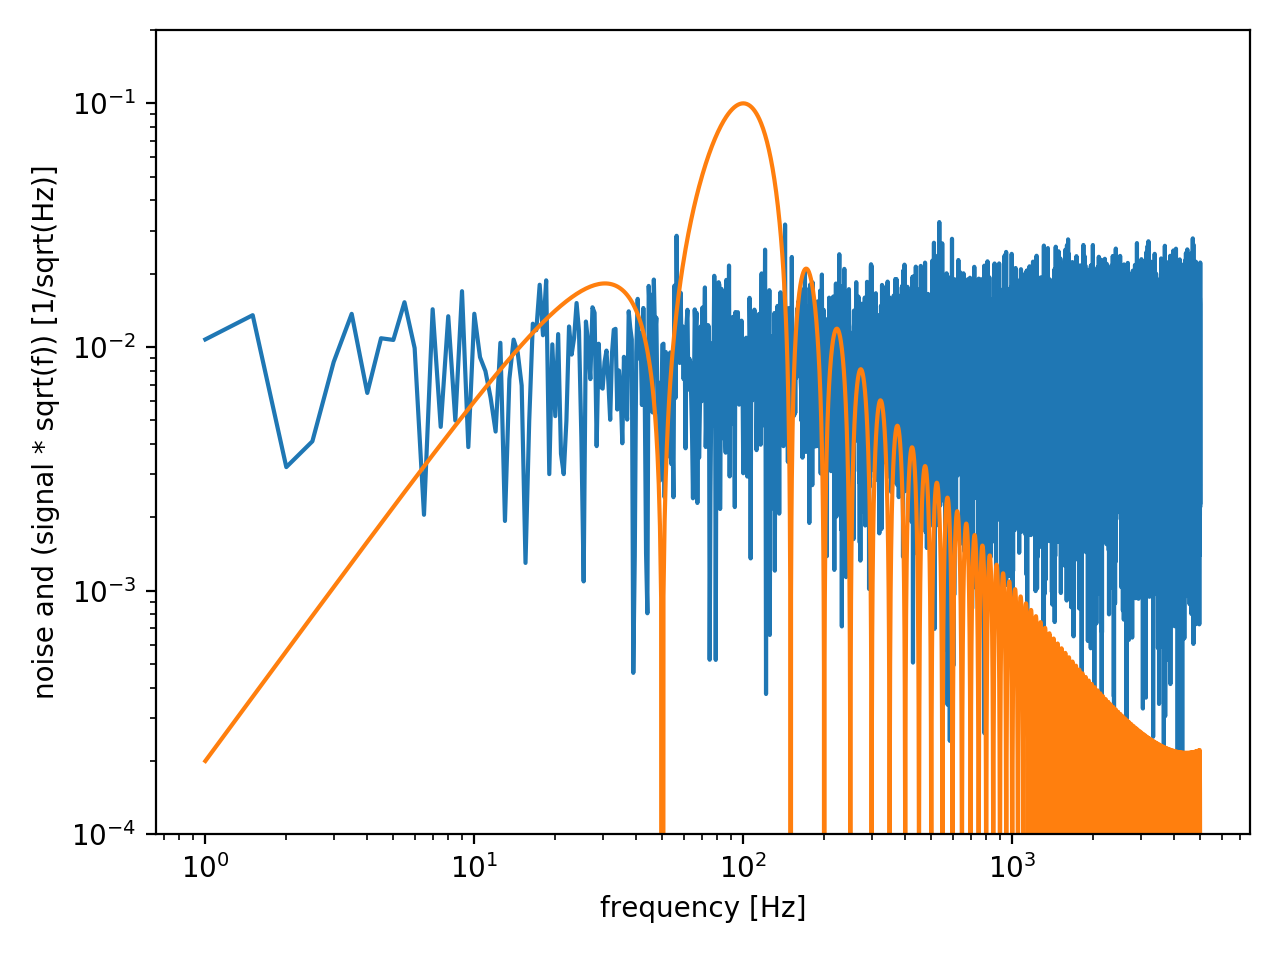

In [15]:
plt.figure()
plt.loglog(frequencies[2:], np.abs(noise_fourier[2:]))
plt.loglog(frequencies[2:], np.sqrt(frequencies[2:]) * np.abs(signal_fourier[2:]))
plt.ylim(1.e-4, 0.2)
plt.xlabel('frequency [Hz]')
plt.ylabel('noise and (signal * sqrt(f)) [1/sqrt(Hz)]')
plt.tight_layout()

## Properties of signal and noise

In [70]:
# Noise-spectral density
psd = np.real(np.dot(noise_fourier, np.conj(noise_fourier))) * df / frequencies.max()

print('noise power spectral density = {:.2e} 1/Hz'.format(psd))

noise power spectral density = 1.01e-04 1/Hz


In [71]:
# Signal power

signal_power = 2 * np.real(np.dot(signal_fourier, np.conj(signal_fourier))) * df
# factor of two is a result of using only positive frequencies (rfft instead of fft)
# Let's check if Plancherel's theorem holds 

print("Checking Plancherel's theorem\nratio of frequency-domain and time-domain power is {:.4f}".\
      format(signal_power / (np.real(np.dot(signal, np.conj(signal))) * dt)))

Checking Plancherel's theorem
ratio of frequency-domain and time-domain power is 1.0000


In [72]:
# signal-to-noise ratio

optimal_snr = np.sqrt(signal_power / psd)
print('The optimal SNR of the signal is {:.1f}'.format(optimal_snr))

The optimal SNR of the signal is 10.0


## Matched filter example

In [73]:
# Placing the signal at a random location into the noise

secret_signal_location = np.random.randint(0, data_size - signal_size)
noise_plus_signal = noisy_data.copy()
noise_plus_signal[secret_signal_location:secret_signal_location + signal_size] += signal

<IPython.core.display.Javascript object>


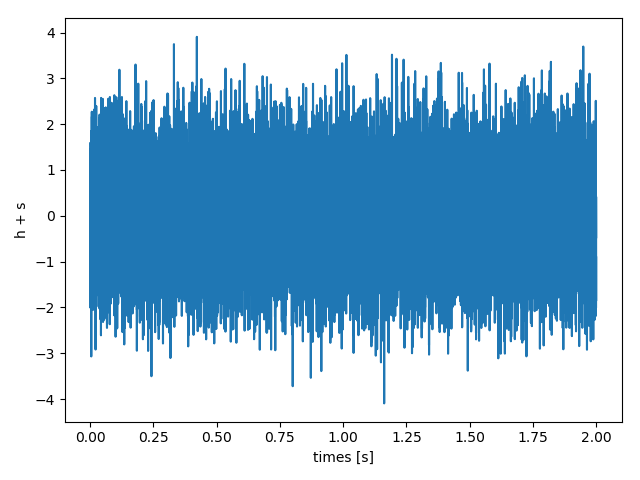

In [74]:
plt.figure()
plt.plot(data_times, noise_plus_signal)
plt.xlabel('times [s]')
plt.ylabel('h + s')
plt.tight_layout()

In [75]:
# Calculate the inner product (overlap) for all possible time shifts of the signal

noise_signal_fourier = np.fft.rfft(noise_plus_signal, norm=None) * dt  # Fourier transform of h + s 

overlap = np.real(np.fft.irfft(noise_signal_fourier * np.conj(signal_fourier) / psd) * df) \
            * data_size / optimal_snr

<IPython.core.display.Javascript object>


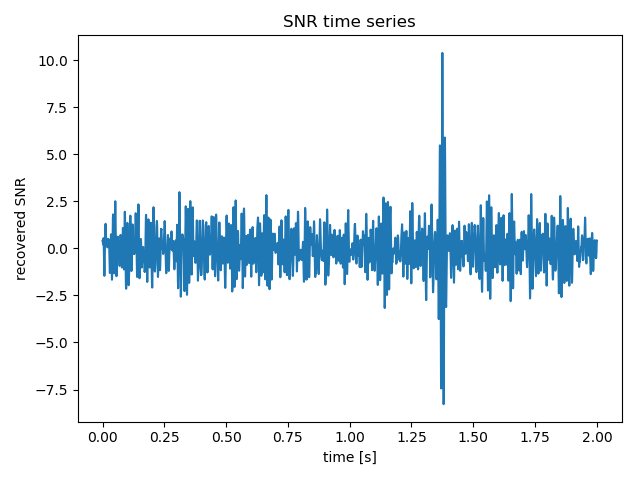

In [76]:
plt.figure()
plt.plot(data_times, overlap)
plt.xlabel('time [s]')
plt.ylabel('recovered SNR')
plt.title('SNR time series')
plt.tight_layout()

In [77]:
print('The recovered injection index was {:d}\n'.format(overlap.argmax()) + \
     'The signal was injected at index {:d}\n'.format(secret_signal_location) + \
     'The recovered SNR is {:.2f}'.format(overlap.max()))

The recovered injection index was 13749
The signal was injected at index 13749
The recovered SNR is 10.40
